In [1]:
# ! pip show tensorflow
# ! pip show tensorflow-gpu
# !pip show keras

In [2]:
!pwd

/masvol/heartsmart/unet_model


In [3]:
import cv2 
from IPython.utils import io
import glob
import cv2
import dicom,  re, sys
from dicom.datadict import dictionary_keyword
import dicom.UID
from dicom.dataset import Dataset, FileDataset
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
import pandas as pd
np.random.seed(1234)
import matplotlib.pyplot as plt

%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

import datetime, time
import scipy.ndimage

import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import binary_crossentropy
import keras.backend as K

#Fix the random seeds for numpy (this is for Keras) and for tensorflow backend to reduce the run-to-run variance
from numpy.random import seed
seed(100)
from tensorflow import set_random_seed
set_random_seed(200)

from helper_utilities import * 

import matplotlib.pyplot as plt
%matplotlib inline

print("\nSuccessfully imported packages!!!\n")


/usr/local/lib/python3.5/dist-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
Using TensorFlow backend.



Successfully imported packages!!!



In [4]:
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
# #config.gpu_options.per_process_gpu_memory_fraction = 0.4
# #config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# #sess.run(yourcommand)

In [ ]:
# https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=resize#cv2.resize
#cv2.Resize(src, dst, interpolation=CV_INTER_LINEAR)
# INTER_NEAREST - a nearest-neighbor interpolation
# INTER_LINEAR - a bilinear interpolation (used by default)
# INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives 
#                 moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
# INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
# INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

# To shrink an image, it will generally look best with CV_INTER_AREA interpolation, whereas to enlarge an image, 
# it will generally look best with CV_INTER_CUBIC (slow) or CV_INTER_LINEAR (faster but still looks OK).


## Methods to extract sunnybrook contour files and corresponding image files 
#### And save them as 4d numpy arrays

Mapping ground truth contours to images...
Shuffle data
/masvol/data/sunnybrook/sunnybrookContoursPart3/TrainingDataContours/SC-HF-NI-36/contours-manual/IRCCI-expert/IM-0001-0229-icontour-manual.txt /masvol/data/sunnybrook/sunnybrookContoursPart3/TrainingDataContours/SC-HF-I-01/contours-manual/IRCCI-expert/IM-0001-0128-icontour-manual.txt
Number of examples: 260
Contour 0 : SC-HF-NI-36 229
Contour -1 : SC-HF-I-1 128
Done mapping ground truth contours to images

extracting train...
Processing 234 images and labels...


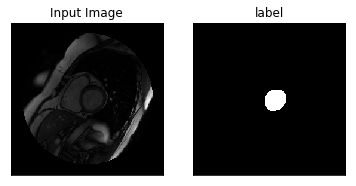

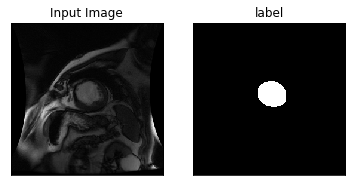

In [5]:
SAX_SERIES = {
    # challenge training
    "SC-HF-I-1": "0004",
    "SC-HF-I-2": "0106",
    "SC-HF-I-4": "0116",
    "SC-HF-I-40": "0134",
    "SC-HF-NI-3": "0379",
    "SC-HF-NI-4": "0501",
    "SC-HF-NI-34": "0446",
    "SC-HF-NI-36": "0474",
    "SC-HYP-1": "0550",
    "SC-HYP-3": "0650",
    "SC-HYP-38": "0734",
    "SC-HYP-40": "0755",
    "SC-N-2": "0898",
    "SC-N-3": "0915",
    "SC-N-40": "0944",
}

SUNNYBROOK_ROOT_PATH = "/masvol/data/sunnybrook/"

TRAIN_CONTOUR_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                            "sunnybrookContoursPart3",
                            "TrainingDataContours")
TRAIN_IMG_PATH = os.path.join(SUNNYBROOK_ROOT_PATH,
                        "challenge_training")

def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def shrink_case(case):
    toks = case.split("-")
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Contour(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        match = re.search(r"/([^/]*)/contours-manual/IRCCI-expert/IM-0001-(\d{4})-icontour-manual.txt", ctr_path)
        self.case = shrink_case(match.group(1))
        self.img_no = int(match.group(2))
    
    def __str__(self):
        return "<Contour for case %s, image %d>" % (self.case, self.img_no)
    
    __repr__ = __str__



def load_contour(contour, img_path):
    filename = "IM-%s-%04d.dcm" % (SAX_SERIES[contour.case], contour.img_no)
    full_path = os.path.join(img_path, contour.case, filename)
    f = dicom.read_file(full_path)
    img = f.pixel_array.astype(np.int)
    height, width = img.shape
    if height != 256 or width !=256:
        print ("img: ", contour.img_no, height, width)
    
    ctrs = np.loadtxt(contour.ctr_path, delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
    return img, label, full_path


    
def get_all_contours(contour_path):
    contours = [os.path.join(dirpath, f)
        for dirpath, dirnames, files in os.walk(contour_path)
        for f in fnmatch.filter(files, 'IM-0001-*-icontour-manual.txt')]
    print("Shuffle data")
    np.random.shuffle(contours)
    print (contours[0], contours[-1])
    print("Number of examples: {:d}".format(len(contours)))
    extracted = list(map(Contour, contours))
    print ("Contour 0 :", extracted[0].case, extracted[0].img_no)
    print ("Contour -1 :", extracted[-1].case, extracted[-1].img_no)


    return extracted

def export_all_contours(contours, img_path):

    counter_img = 0
    counter_label = 0
    batchsz = 260
    print("Processing {:d} images and labels...".format(len(contours)))
    for i in range(int(np.ceil(len(contours) / float(batchsz)))):
        batch = contours[(batchsz*i):(batchsz*(i+1))]
        if len(batch) == 0:
            break
        imgs, labels = [], []
        img_path_list, contour_path_list = [],[]
        for idx,ctr in enumerate(batch):
            try:
                img, label, fullpath = load_contour(ctr, img_path)
                imgs.append(img)
                labels.append(label)
                img_path_list.append(fullpath)
                contour_path_list.append(ctr.ctr_path)
                
                if idx % 200 == 0:
                    #print ctr
                    #print "Img :", img.shape, img.min(), img.max()
                    #print "Label :", label.shape, label.min(), label.max()
                    plt.subplot(121),plt.imshow(img, cmap = 'gray')
                    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
                    plt.subplot(122),plt.imshow(label, cmap = 'gray')
                    plt.title('label'), plt.xticks([]), plt.yticks([])
                    plt.show()
                    
#                     plt.imshow(img,cmap='gray')
#                     plt.show()
#                     plt.imshow(label, cmap='gray')
#                     plt.show()
            except IOError:
                continue

    return imgs, labels, img_path_list, contour_path_list

if __name__== "__main__":
    SPLIT_RATIO = 0.1
    print("Mapping ground truth contours to images...")
    ctrs = get_all_contours(TRAIN_CONTOUR_PATH)
    val_ctrs = ctrs[0:int(SPLIT_RATIO*len(ctrs))]
    train_ctrs = ctrs[int(SPLIT_RATIO*len(ctrs)):]
    print("Done mapping ground truth contours to images")
    print("\nextracting train...")
    train_imgs, train_labels, img_path_list, contour_path_list = export_all_contours(train_ctrs, TRAIN_IMG_PATH)

In [6]:
train_imgs.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
import scipy.misc

for i in range (2,4):
    full_path = img_path_list[i]
    f = dicom.read_file(full_path)
    fx, fy = f.PixelSpacing
    print ("pixel spacing", fx, fy)
    img = f.pixel_array.astype(np.int)
    height, width = img.shape
    if height != 256 or width !=256:
        print ("img: ", contour.img_no, height, width)

    ctrs = np.loadtxt(contour_path_list[i], delimiter=" ").astype(np.int)
    label = np.zeros_like(img, dtype="uint8")
    cv2.fillPoly(label, [ctrs], 1)
#     scipy.misc.imsave('sb_image'+str(i)+'.jpg', img)
#     scipy.misc.imsave('sb_label'+str(i)+'.jpg', label)
    
    f, axs = plt.subplots(1,3,figsize=(15,15))
    plt.subplot(131),plt.imshow(img)
    plt.title('Image '+str(i)), plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(label)
    plt.title('Prediction'), plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(img), plt.imshow(label, 'binary', interpolation='none', alpha=0.3)
    plt.title('Overlay'), plt.xticks([]), plt.yticks([])
    plt.show()

In [ ]:
# INTER_NEAREST - a nearest-neighbor interpolation
# INTER_LINEAR - a bilinear interpolation (used by default)
# INTER_AREA - resampling using pixel area relation. It may be a preferred method for image decimation, as it gives 
#                 moire’-free results. But when the image is zoomed, it is similar to the INTER_NEAREST method.
# INTER_CUBIC - a bicubic interpolation over 4x4 pixel neighborhood
# INTER_LANCZOS4 - a Lanczos interpolation over 8x8 pixel neighborhood

In [ ]:
orig_img_list = []
orig_lbl_list = []
resized_img_list,resized2a_img_list,resized2b_img_list,resized2c_img_list  = [], [], [], []
resized_lbl_list,resized2a_lbl_list,resized2b_lbl_list,resized2c_lbl_list  = [], [], [], []
cropped_img_list,cropped2a_img_list,cropped2b_img_list,cropped2c_img_list  = [], [], [], []
cropped_lbl_list,cropped2a_lbl_list,cropped2b_lbl_list,cropped2c_lbl_list  = [], [], [], []
crop_pixelcount_list,crop2a_pixelcount_list,crop2b_pixelcount_list = [], [], []

print ("samples:", len(img_path_list))
for i in range (len(img_path_list)):
    full_path = img_path_list[i]
    f = dicom.read_file(full_path)
    fx1, fy1 = f.PixelSpacing
    #fx = 1; fy=1
    #print ("pixel spacing", fx1, fy1)
    
    img1 = f.pixel_array.astype(np.int)
    x, y = img1.shape
    if height != 256 or width !=256:
        print ("img: ", contour.img_no, x,y)
    ctrs = np.loadtxt(contour_path_list[i], delimiter=" ").astype(np.int)
    label1 = np.zeros_like(img1, dtype="uint8")
    cv2.fillPoly(label1, [ctrs], 1)
    img1 = img1.astype(np.uint16)
    #print (img1.shape, type(img1))
    orig_img_list.append(img1)
    orig_lbl_list.append(label1)
#     img = np.ndarray((x,y,1), dtype=np.int)
#     lbl = np.ndarray((x,y,1), dtype=np.uint8)
    img2 = cv2.resize(img1, (0, 0), fx=fx, fy=fy)
    label2 = cv2.resize(label1, (0, 0), fx=fx, fy=fy)
    resized_img_list.append(img2)
    resized_lbl_list.append(label2)
    img2a = cv2.resize(img1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_AREA)
    label2a = cv2.resize(label1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_AREA)
    resized2a_img_list.append(img2a)
    resized2a_lbl_list.append(label2a)
    img2b = cv2.resize(img1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    label2b = cv2.resize(label1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_CUBIC)
    resized2b_img_list.append(img2b)
    resized2b_lbl_list.append(label2b)
    img2c = cv2.resize(img1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_LANCZOS4)
    label2c = cv2.resize(label1, (0, 0), fx=fx, fy=fy, interpolation = cv2.INTER_LANCZOS4)
    resized2c_img_list.append(img2c)
    resized2c_lbl_list.append(label2c)
    
    #print ("resized images: ", img2.shape, label2.shape)
    cropx, cropy = 256, 256
    img3 = crop_center(img2,cropx,cropy)
    label3 = crop_center(label2,cropx,cropy)
    cropped_img_list.append(img3)
    cropped_lbl_list.append(label3)
    crop_pixelcount_list.append(np.count_nonzero(label3))
    img3a = crop_center(img2a,cropx,cropy)
    label3a = crop_center(label2a,cropx,cropy)
    cropped2a_img_list.append(img3a)
    cropped2a_lbl_list.append(label3a)
    crop2a_pixelcount_list.append(np.count_nonzero(label3a))
    img3b = crop_center(img2b,cropx,cropy)
    label3b = crop_center(label2b,cropx,cropy)
    cropped2b_img_list.append(img3b)
    cropped2b_lbl_list.append(label3b)
    crop2b_pixelcount_list.append(np.count_nonzero(label3b))
    img3c = crop_center(img2c,cropx,cropy)
    label3c = crop_center(label2c,cropx,cropy)
    cropped2c_img_list.append(img3c)
    cropped2c_lbl_list.append(label3c)
    #print ("cropped images: ", img3.shape, label3.shape)
    #img3 = cv2.resize(img2,(300, 300), interpolation = cv2.INTER_CUBIC)



    
#     f, axs = plt.subplots(1,3,figsize=(30,10))
#     plt.subplot(131),plt.imshow(img1)
#     plt.title('Image '+str(i))#, plt.xticks([]), plt.yticks([])
#     plt.subplot(132),plt.imshow(label1)
#     plt.title('Prediction')#, plt.xticks([]), plt.yticks([])
#     plt.subplot(133),plt.imshow(img1), plt.imshow(label1, 'binary', interpolation='none', alpha=0.3)
#     plt.title('Overlay') #, plt.xticks([]), plt.yticks([])
#     plt.show()
#     f, axs = plt.subplots(1,3,figsize=(30,10))
#     plt.subplot(131),plt.imshow(img2)
#     plt.title('Image '+str(i))#, plt.xticks([]), plt.yticks([])
#     plt.subplot(132),plt.imshow(label2)
#     plt.title('Prediction')#, plt.xticks([]), plt.yticks([])
#     plt.subplot(133),plt.imshow(img2), plt.imshow(label2, 'binary', interpolation='none', alpha=0.3)
#     plt.title('Overlay') #, plt.xticks([]), plt.yticks([])
#     plt.show()
#     f, axs = plt.subplots(1,3,figsize=(30,10))
#     plt.subplot(131),plt.imshow(img3)
#     plt.title('Image '+str(i))#, plt.xticks([]), plt.yticks([])
#     plt.subplot(132),plt.imshow(label3)
#     plt.title('Prediction')#, plt.xticks([]), plt.yticks([])
#     plt.subplot(133),plt.imshow(img3), plt.imshow(label3, 'binary', interpolation='none', alpha=0.3)
#     plt.title('Overlay') #, plt.xticks([]), plt.yticks([])
#     plt.show()

In [ ]:
print (max(crop_pixelcount_list),crop_pixelcount_list.index(max(crop_pixelcount_list)),  \
       min(crop_pixelcount_list),crop_pixelcount_list.index(min(crop_pixelcount_list)) )

In [ ]:
print (" index : orig   :   linear   :   area   :   cubic:lanczos,%increase")
j=0
for i in range (len(orig_lbl_list)):
    delta = (np.count_nonzero(cropped2b_lbl_list[i]) - np.count_nonzero(cropped_lbl_list[i]))/np.count_nonzero(cropped_lbl_list[i]) 
    if  delta > .01:
        j +=1
        print ("%d  : %d   :  %d   : %d   : %d   : %d  , %f "%(i, np.count_nonzero(orig_lbl_list[i]),np.count_nonzero(cropped_lbl_list[i]), \
                      np.count_nonzero(cropped2a_lbl_list[i]), np.count_nonzero(cropped2b_lbl_list[i]), np.count_nonzero(cropped2c_lbl_list[i]), \
                                    (np.count_nonzero(cropped2b_lbl_list[i]) - np.count_nonzero(cropped_lbl_list[i]))/np.count_nonzero(cropped_lbl_list[i]) ))
print ("Total Count : ", j)

In [ ]:
mylist = [13,56, 32,75,222, 157]
for i in mylist:
    px1 = np.count_nonzero(cropped_lbl_list[i])
    px2 = np.count_nonzero(cropped2b_lbl_list[i])
    f, axs = plt.subplots(1,2,figsize=(30,20))
    plt.subplot(121),plt.imshow(cropped_lbl_list[i])
    plt.title('NTER_LINEAR '+str(i)+" contour pixels:" + str(px1))#, plt.xticks([]), plt.yticks([]
    plt.subplot(122),plt.imshow(cropped2b_lbl_list[i])
    plt.title('NTER_CUBIC '+str(i)+" contour pixels:" + str(px2))#, plt.xticks([]), plt.yticks([]


In [ ]:
mylist = [7,49,95,120]
for i in mylist:
    px1 = np.count_nonzero(cropped_lbl_list[i])
    px2 = np.count_nonzero(cropped2b_lbl_list[i])
    f, axs = plt.subplots(1,2,figsize=(30,20))
    plt.subplot(121),plt.imshow(cropped_lbl_list[i])
    plt.title('NTER_LINEAR '+str(i)+" contour pixels:" + str(px1))#, plt.xticks([]), plt.yticks([]
    plt.subplot(122),plt.imshow(cropped2b_lbl_list[i])
    plt.title('NTER_CUBIC '+str(i)+" contour pixels:" + str(px2))#, plt.xticks([]), plt.yticks([]

In [ ]:
for i in range (5):
    f, axs = plt.subplots(1,3,figsize=(30,10))
    plt.subplot(131),plt.imshow(orig_lbl_list[i])
    plt.title('original '+str(i))#, plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(cropped_lbl_list[i])
    plt.title('linear interpolation')#, plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(cropped2b_lbl_list[i])
    plt.title('cubic interpolation')

In [ ]:
for i in range (2):
    fig = plt.figure(figsize=(10,10))
    plt.imshow(orig_lbl_list[i])
    plt.show()
#     fig = plt.figure(figsize=(10,10))
#     plt.imshow(resized_lbl_list[i])
#     plt.show()
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cropped_lbl_list[i])
    plt.show()
    
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cropped2b_lbl_list[i])
    plt.show()
    #fig.savefig('/masvol/heartsmart/unet_model/'+'acdc176_label_'+str(i)+'.png')

In [ ]:
lb = orig_lbl_list[0]
lb.max(), lb.min()
np.count_nonzero(lb)


In [8]:
a = np.zeros((2, 3, 4))
a

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [41]:
#imgfile = '/masvol/heartsmart/unet_model/baseline/data/combined_1_3_176_test_images.npy'
imgfile = '/masvol/output/acdc/norm/1/3/unet_model/data/combined_1_3_0_176_test_images.npy'
img = load_images(imgfile, normalize= False)

------------------------------
load np arrays of images ...
------------------------------
Loading files :  /masvol/output/acdc/norm/1/3/unet_model/data/combined_1_3_0_176_test_images.npy
shape, max, min, mean of images: (270, 176, 176, 1) 1.0 0.0 0.20691323


In [34]:
imgx = img[0:10].copy()

In [35]:
imgx.max(), imgx.min()

(401, 5)

In [36]:
x_min = imgx.min(axis=(1, 2), keepdims=True)
x_max = imgx.max(axis=(1, 2), keepdims=True)
img2 = (imgx - x_min)/(x_max-x_min)

In [37]:
x_mean = imgx.mean(axis=(1, 2), keepdims=True)
x_std = imgx.std(axis=(1, 2), keepdims=True)
img3 = (imgx - x_mean)/(x_std)

In [38]:
x_mean.shape, img3.shape

((10, 1, 1, 1), (10, 176, 176, 1))

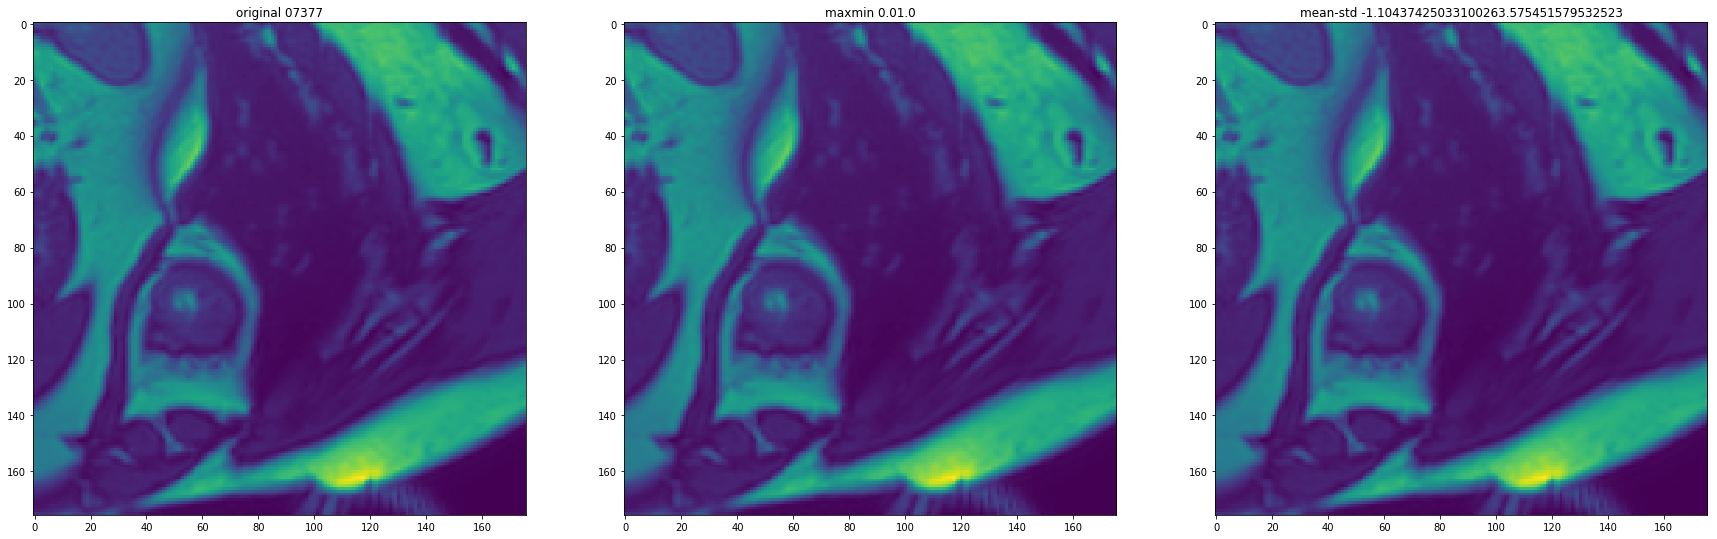

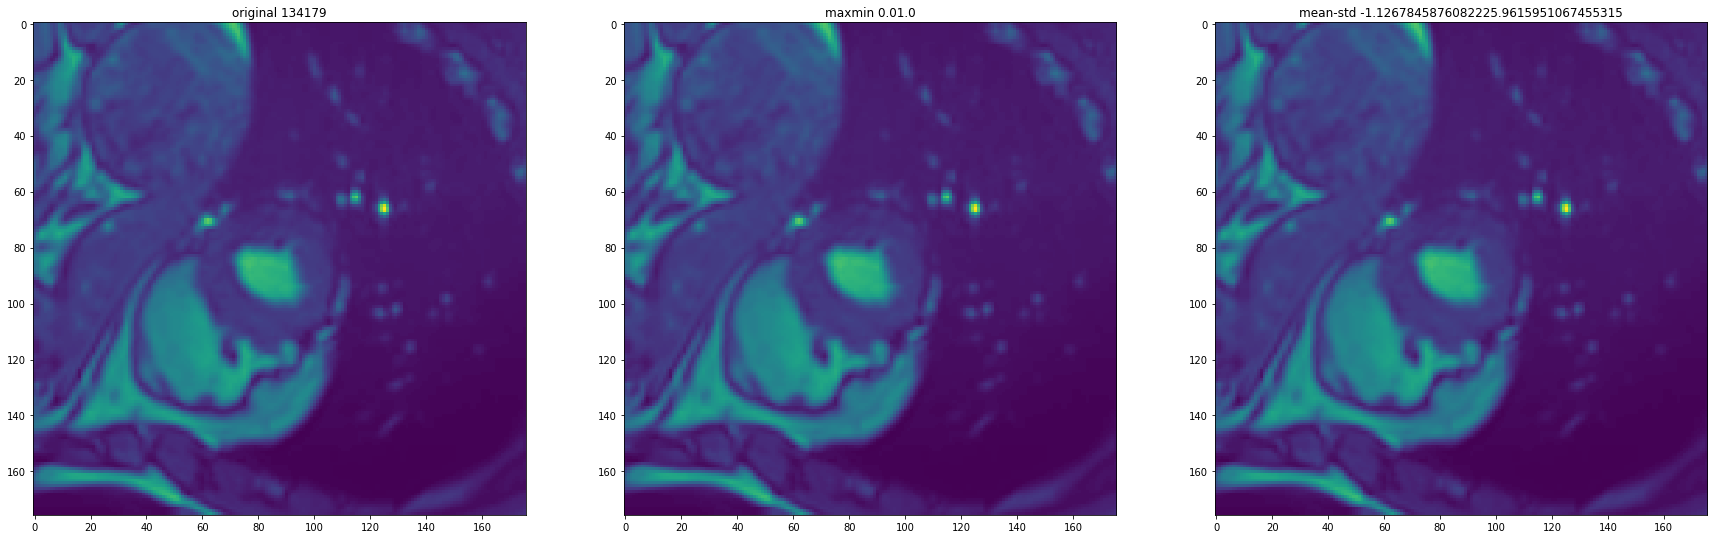

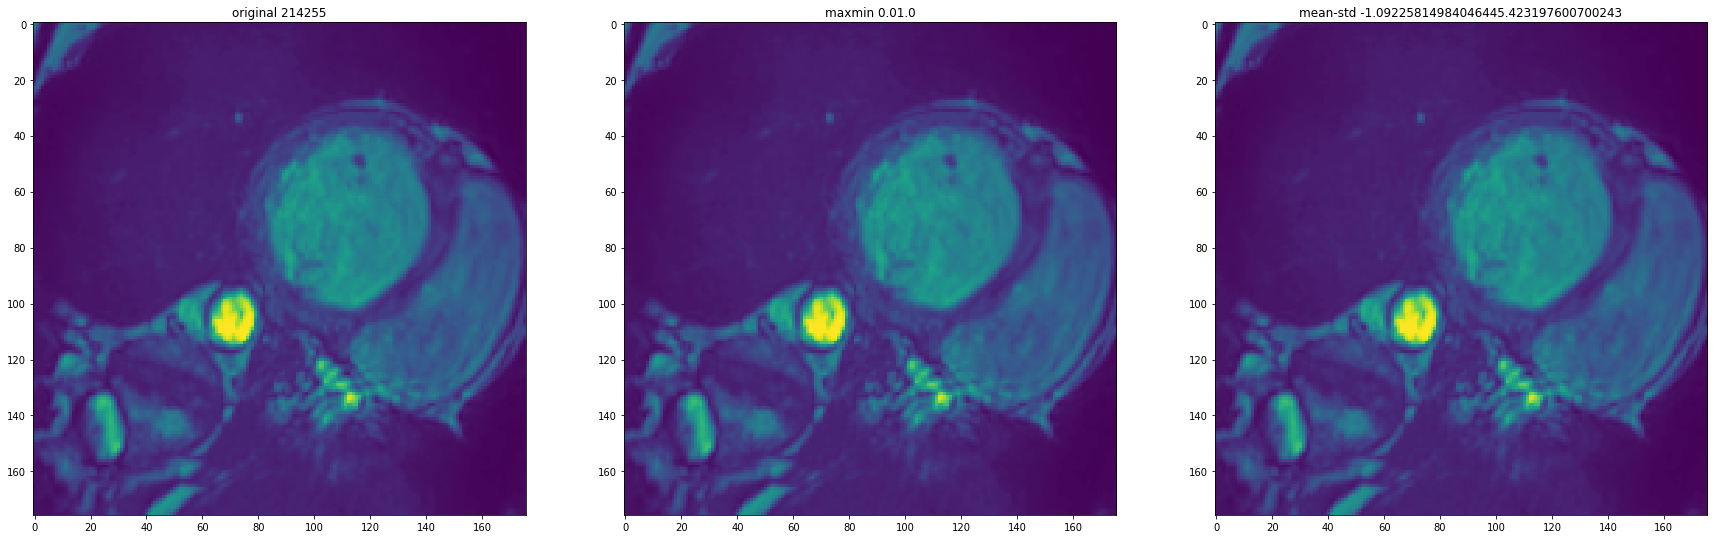

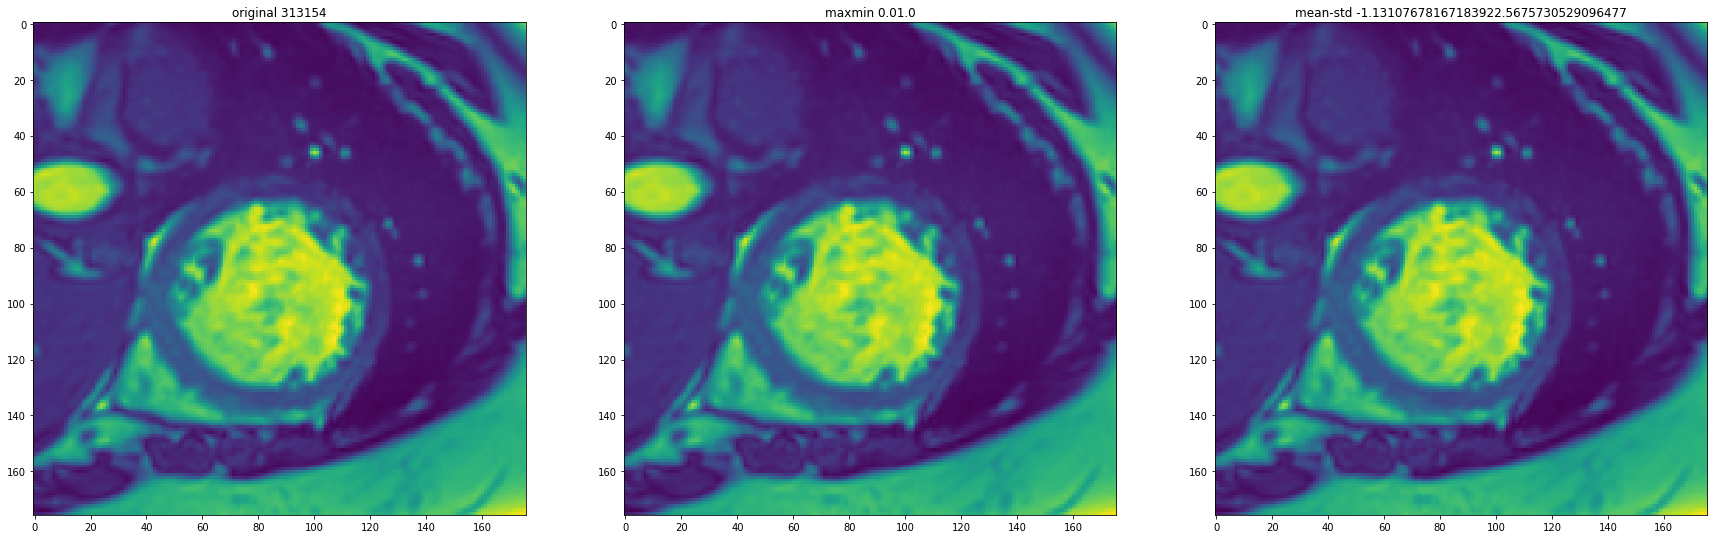

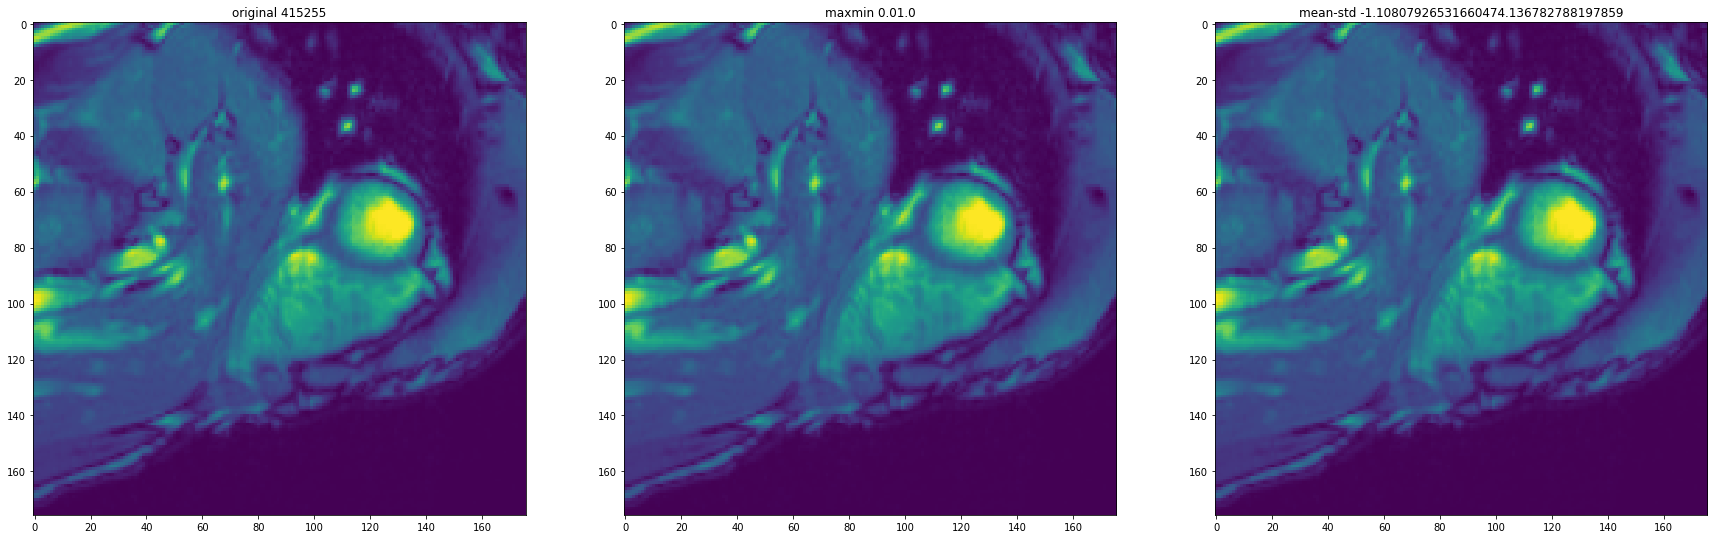

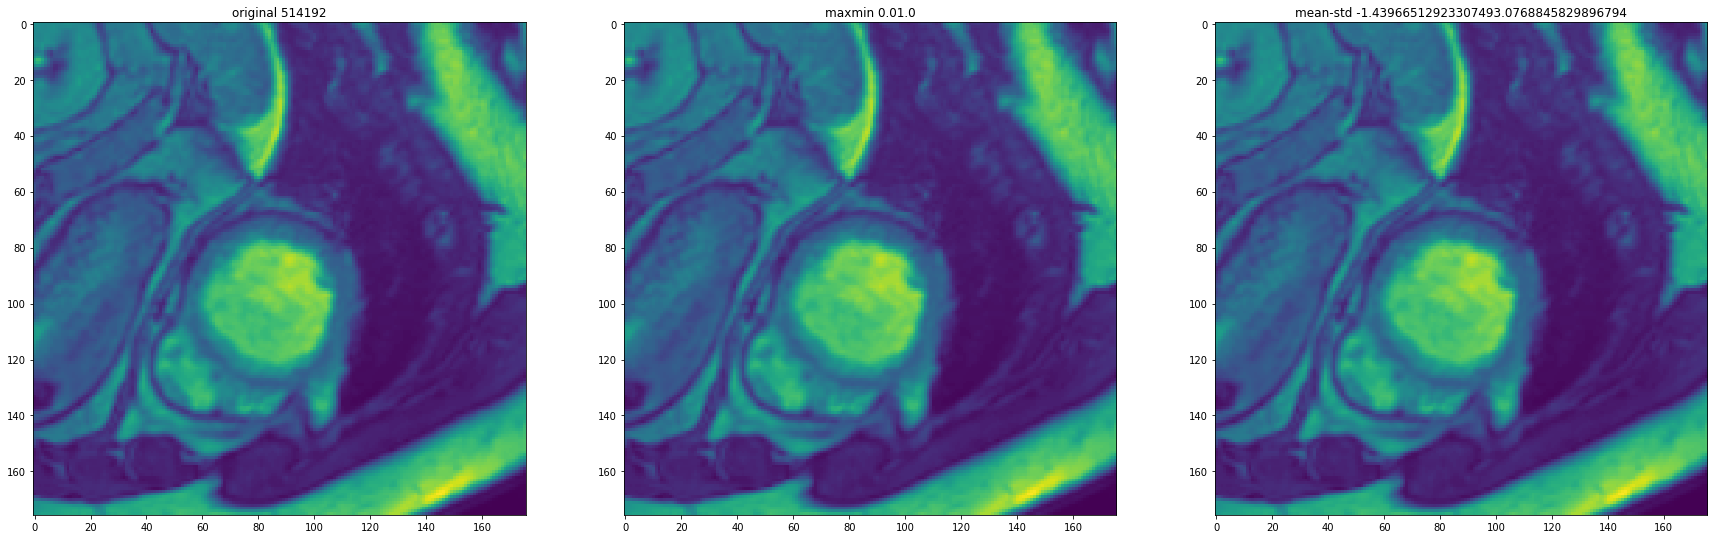

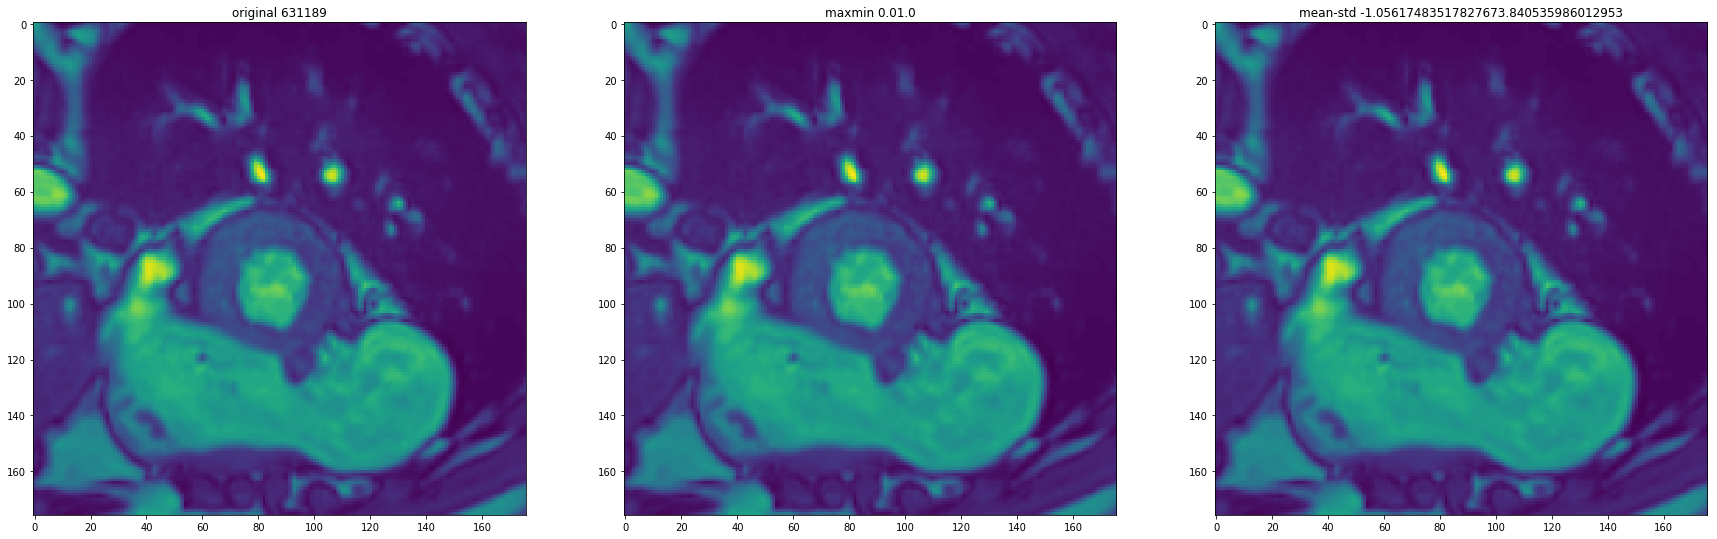

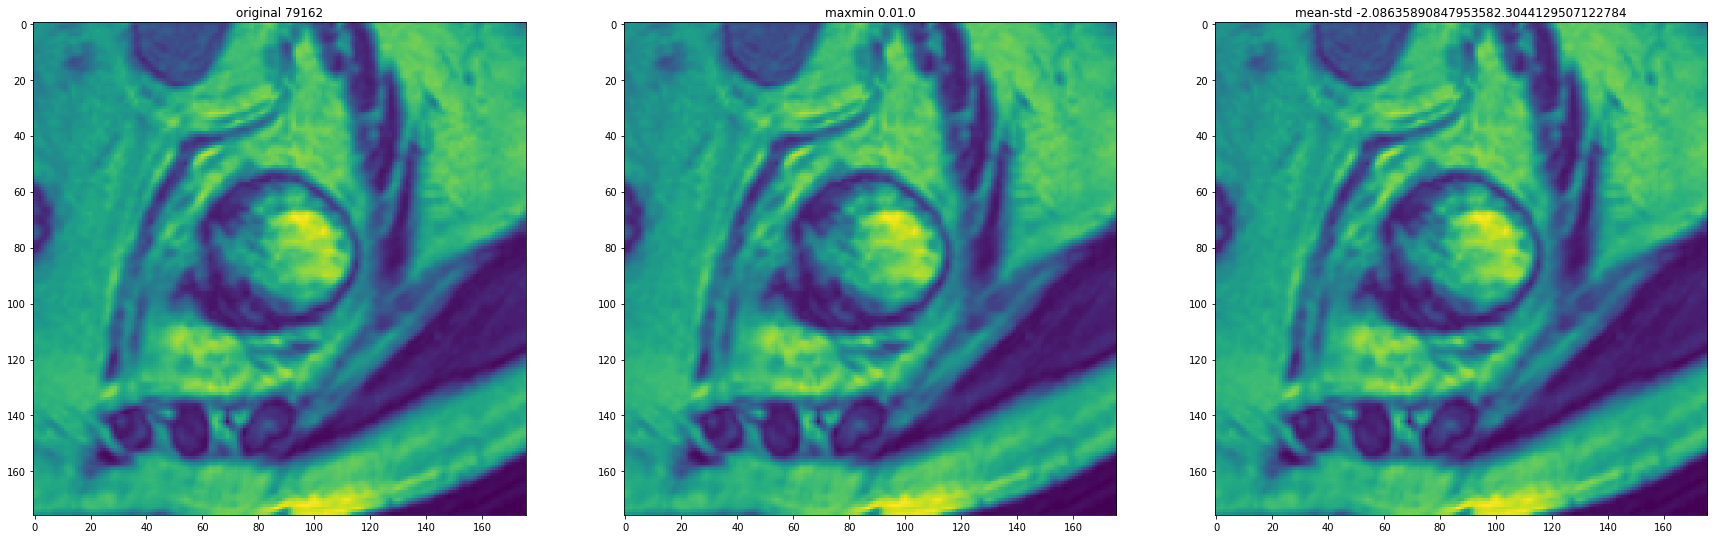

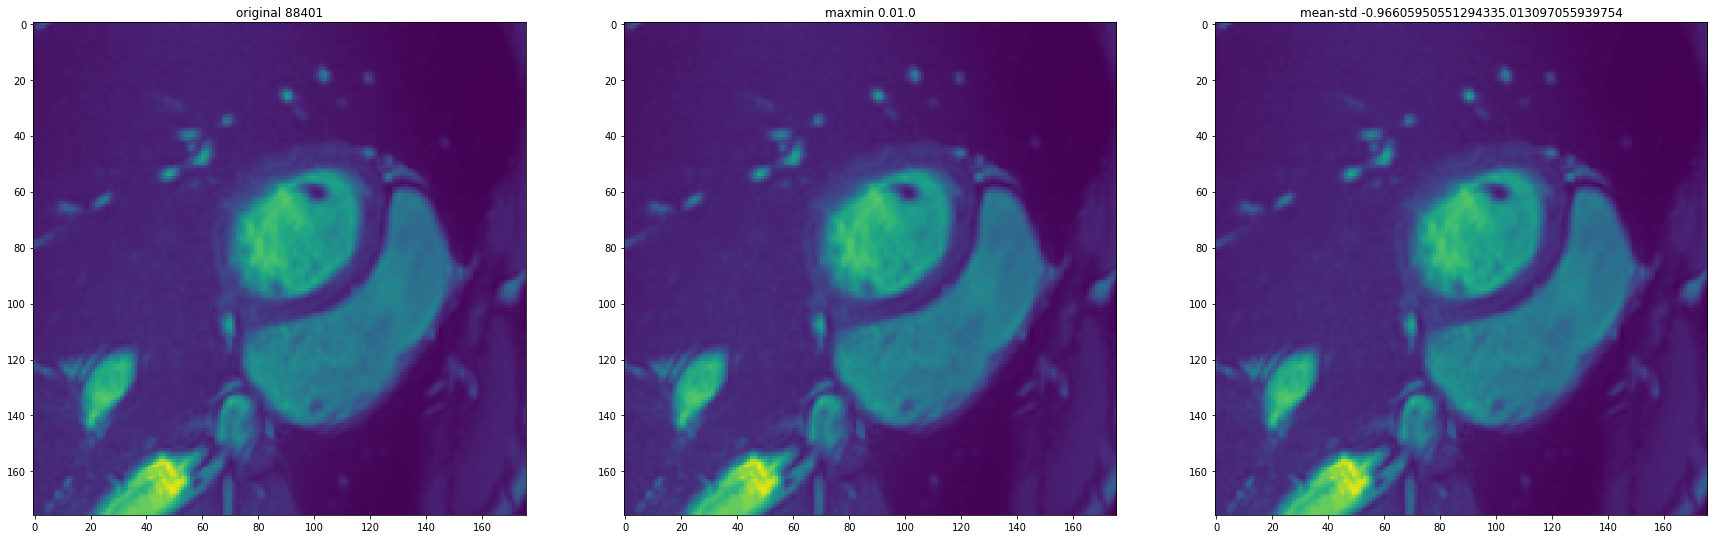

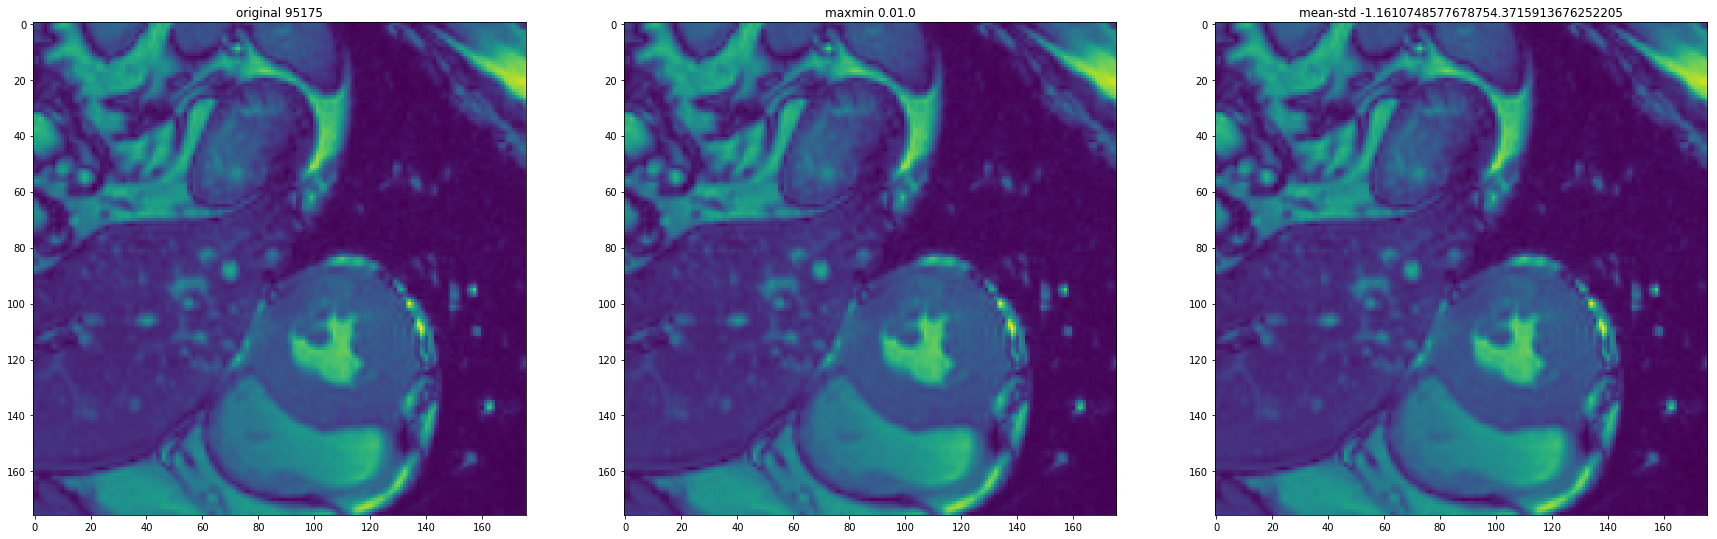

In [40]:
x, y = 176, 176
for i in range (10):
    f, axs = plt.subplots(1,2,figsize=(30,10))
    plt.subplot(131),plt.imshow(imgx[i].reshape(x, y))
    plt.title('original '+str(i) + str(imgx[i].min()) + str(imgx[i].max()) )#, plt.xticks([]), plt.yticks([])
    plt.subplot(132),plt.imshow(img2[i].reshape(x, y))
    plt.title('maxmin ' + str(img2[i].min()) + str(img2[i].max()))#, plt.xticks([]), plt.yticks([])
    plt.subplot(133),plt.imshow(img3[i].reshape(x, y))
    plt.title('mean-std ' + str(img3[i].min()) + str(img3[i].max()) )